In [522]:
import pandas as pd
from pycaret.regression import *

df = pd.read_csv('consumption_temp.csv')

start_time = '2022-08-07 21:00:00'
end_time = '2022-12-07 21:00:00'
location = 'oslo'
use_yr = True

start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

data = df[df['location'].str.lower() == location.lower()]
data['time'] = pd.to_datetime(data['time'])

# Filter the training data based on the start and end time
data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

# Create hour feature
data['hour'] = data['time'].dt.hour
# Create weekday feature
data['weekday'] = data['time'].dt.weekday
# Create month feature
data['month'] = data['time'].dt.month


In [523]:
# Create a new dataframe with temperature data from yr for the same time period to train on
yr_df = pd.read_csv('../yr-data/weather_data_oslo.csv')

# Converting timestamp to same format as the aneo data
yr_df['time'] = pd.to_datetime(yr_df['timestamp'], utc=True)
yr_df['time'] = pd.to_datetime(yr_df['time'].dt.strftime('%Y-%m-%d %H:%M:%S'))

# Remove unnecessary columns
yr_df = yr_df[['time', 'avg_temp']]
yr_df = yr_df.rename(columns={'avg_temp': 'temperature'})

yr_df = yr_df[(yr_df['time'] >= start_time) & (yr_df['time'] <= end_time)]

dataWitoutTemp = data.copy().drop(columns=['temperature'])

aneo_yr = pd.merge(dataWitoutTemp, yr_df, on='time', how='left')

aneo_yr.head()

,time,location,consumption,hour,weekday,month,temperature
0,2022-08-07 21:00:00,oslo,3.138082,21,6,8,15.2
1,2022-08-07 22:00:00,oslo,2.688283,22,6,8,14.4
2,2022-08-07 23:00:00,oslo,2.424474,23,6,8,14.1
3,2022-08-08 00:00:00,oslo,2.313385,0,0,8,13.8
4,2022-08-08 01:00:00,oslo,2.267622,1,0,8,13.5


In [514]:
if use_yr:
    train_data = aneo_yr
else:
    train_data = data

# Remove the last 5 days of consumption data
train_data['consumption'] = train_data['consumption'].shift(120)
train_data.dropna(subset=['consumption'], inplace=True)

regression_setup = setup(data=data, target='consumption', session_id=123,
                         numeric_features=['temperature', 'hour', 'weekday', 'month'],
                         ignore_features=['time', 'location'], 
                         transform_target=True, data_split_shuffle=False)

,Description,Value
0,Session id,123
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(2929, 6)"
4,Transformed data shape,"(2929, 4)"
5,Transformed train set shape,"(2050, 4)"
6,Transformed test set shape,"(879, 4)"
7,Ignore features,2
8,Numeric features,3
9,Preprocess,True


In [515]:
# Compare models to select the best one in the next block (comment if already selected)
# best_model = compare_models()


In [516]:
# Create the model with the desired model
model = create_model("rf")

tuned_model = tune_model(model)

final_model = finalize_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0227,0.0011,0.0338,0.7549,0.0172,0.0239
1,0.0239,0.0016,0.0401,0.7289,0.0200,0.0244
2,0.0358,0.0038,0.0617,0.2552,0.0295,0.0352
3,0.0642,0.0068,0.0825,-0.4517,0.0387,0.0600
4,0.0587,0.0062,0.0784,-0.5247,0.0370,0.0550
5,0.0756,0.0075,0.0865,-2.6491,0.0419,0.0738
6,0.0408,0.0026,0.0505,-2.0854,0.0268,0.0449
7,0.0329,0.0018,0.0423,-5.3496,0.0235,0.0391
8,0.0192,0.0006,0.0239,-0.1656,0.0124,0.0201


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0875,0.0093,0.0965,-0.9948,0.0486,0.0928
1,0.0783,0.0089,0.0942,-0.4939,0.0471,0.0821
2,0.0908,0.0117,0.1083,-1.2988,0.0528,0.0916
3,0.0845,0.0120,0.1096,-1.5663,0.0519,0.0807
4,0.0676,0.0074,0.0858,-0.8266,0.0406,0.0635
5,0.0537,0.0043,0.0653,-1.0815,0.0318,0.0525
6,0.0449,0.0030,0.0549,-2.6354,0.0291,0.0493
7,0.0518,0.0035,0.0588,-11.2648,0.0324,0.0612
8,0.0676,0.0049,0.0697,-8.8724,0.0361,0.0703


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


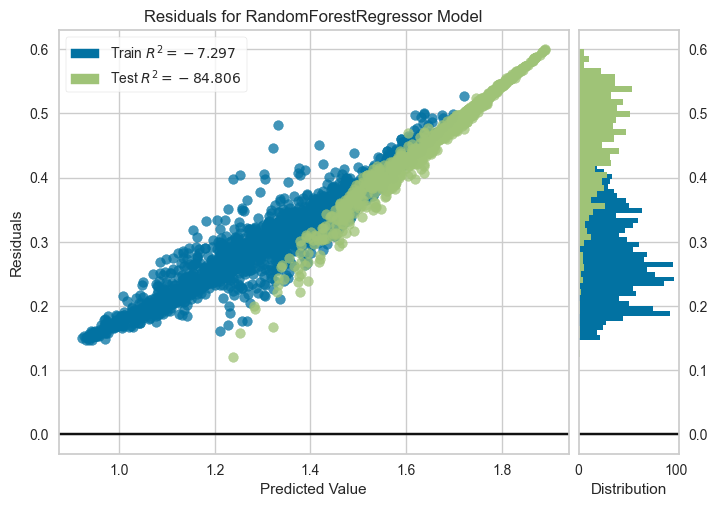

In [517]:
plot_model(final_model)

In [ ]:
plot_model(final_model, plot='feature')

In [518]:
from datetime import timedelta

number_predict_hours = 24

# The last known time from the original data
last_time = data['time'].iloc[-1]

# Generating future timestamps for the next 24 hours (the hours we want to predict)
future_timestamps = [last_time + timedelta(hours=i) for i in range(1, number_predict_hours + 1)]

future_data = df[df['location'].str.lower() == location.lower()]
future_data['time'] = pd.to_datetime(future_data['time'])

# Limit future data to the next 24 hours after the last known time
future_data = future_data[(future_data['time'] > last_time) & (future_data['time'] <= future_timestamps[-1])]
future_hours = future_data['time'].dt.hour
future_weekdays = future_data['time'].dt.weekday
future_months = future_data['time'].dt.month
future_temperatures = future_data['temperature'].values

print(len(future_data))

# Creating the future_data DataFrame, which will be used for the prediction
future_data = pd.DataFrame({
    'time': future_timestamps,
    'temperature': future_temperatures,
    'location': location,
    'hour': future_hours,
    'weekday': future_weekdays,
    'month': future_months
})

# Predict the consumption for the next 24 hours using the trained model
future_data['time'] = pd.to_datetime(future_data['time'])
predictions = predict_model(final_model, data=future_data)

24


In [519]:
predictions

,time,temperature,location,hour,weekday,prediction_label
32792,2022-12-07 22:00:00,-6.5,oslo,22,2,13.668291
32798,2022-12-07 23:00:00,-6.9,oslo,23,2,13.221305
32804,2022-12-08 00:00:00,-6.8,oslo,0,3,11.599905
32810,2022-12-08 01:00:00,-6.5,oslo,1,3,11.493488
32816,2022-12-08 02:00:00,-6.3,oslo,2,3,11.436440
32822,2022-12-08 03:00:00,-6.3,oslo,3,3,11.428073
32828,2022-12-08 04:00:00,-6.1,oslo,4,3,11.373769
32834,2022-12-08 05:00:00,-7.1,oslo,5,3,11.985178
32840,2022-12-08 06:00:00,-7.4,oslo,6,3,12.614717
32846,2022-12-08 07:00:00,-7.3,oslo,7,3,12.845085


In [524]:
import pandas as pd
from pycaret.regression import *

solution = df[df['location'].str.lower() == location.lower()]
solution['time'] = pd.to_datetime(solution['time'])

# Filter the training data based on the start and end time
solution = solution[(solution['time'] > last_time) & (solution['time'] <= future_timestamps[-1])]

# Create hour feature
solution['hour'] = solution['time'].dt.hour
# Create weekday feature
solution['weekday'] = solution['time'].dt.weekday
# Merge the DataFrames
merged_data = predictions.copy()
merged_data['consumption'] = solution['consumption']
merged_data = merged_data.rename(columns={'prediction_label': 'predicted_consumption'})
merged_data.head()

,time,temperature,location,hour,weekday,predicted_consumption,consumption
32792,2022-12-07 22:00:00,-6.5,oslo,22,2,13.668291,14.222321
32798,2022-12-07 23:00:00,-6.9,oslo,23,2,13.221305,13.597456
32804,2022-12-08 00:00:00,-6.8,oslo,0,3,11.599905,13.189309
32810,2022-12-08 01:00:00,-6.5,oslo,1,3,11.493488,13.020150
32816,2022-12-08 02:00:00,-6.3,oslo,2,3,11.436440,12.849883


<AxesSubplot: title={'center': 'Predictions for the next 24 hours'}, xlabel='time', ylabel='MV'>

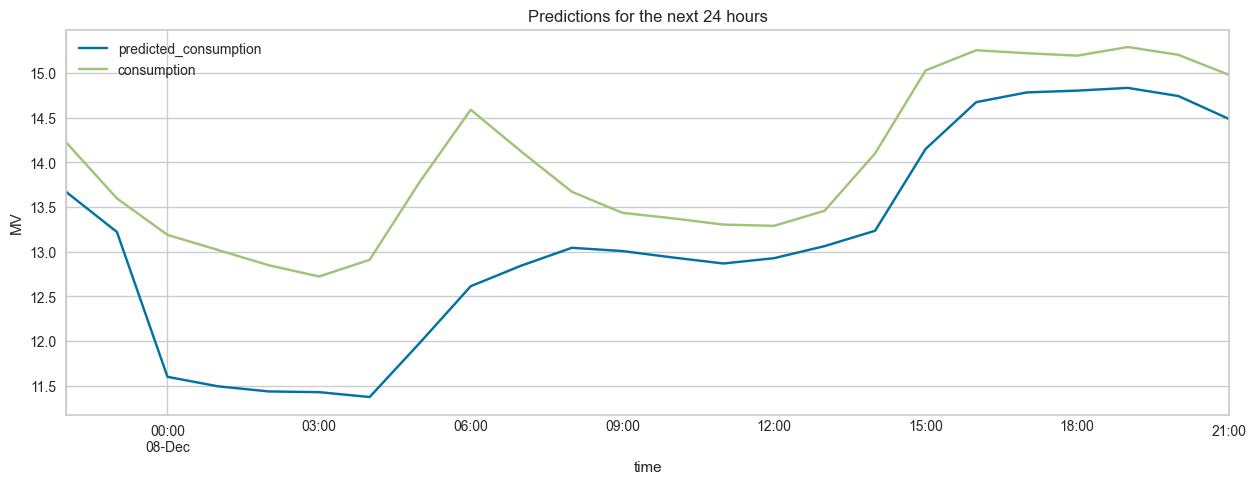

In [525]:
merged_data.plot(x='time', y=['predicted_consumption', 'consumption'], ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours')